In [ ]:
import gymnasium as gym
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set random seeds for reproducibility
tf.random.set_seed(0)
np.random.seed(0)

# --------------------------
# Helper function: Metrics plot
# --------------------------
def plot_metrics(total_rewards, actor_losses, critic_losses, window_1=10, window_2=25):
    """
    Plots the raw metrics and their rolling statistics over windows of window_1 and window_2 episodes.

    Each column corresponds to one metric:
      - Column 1: Total Reward
      - Column 2: Actor Loss
      - Column 3: Critic Loss

    Row 1: Raw metrics.
    Row 2: Rolling mean, median, and std over a window of window_1 episodes.
    Row 3: Rolling mean, median, and std over a window of window_2 episodes.
    """

    # Helper function: Rolling stats
    def plot_rolling(ax, data, window, label):
        # Convert the list to a pandas Series.
        series = pd.Series(data)
        rolling_mean = series.rolling(window=window, min_periods=1).mean()
        rolling_median = series.rolling(window=window, min_periods=1).median()
        rolling_std = series.rolling(window=window, min_periods=1).std()

        # Plot the rolling mean and median.
        ax.plot(episodes, rolling_mean, label="Mean")
        ax.plot(episodes, rolling_median, label="Median")
        # Plot an error band representing +/- the rolling std.
        ax.fill_between(episodes, rolling_mean - rolling_std, rolling_mean + rolling_std,
                        alpha=0.2, label="Std")
        ax.set_title(f"Rolling (window={window}) {label}")
        ax.set_xlabel("Episode")
        ax.legend()

    episodes = range(1, len(total_rewards) + 1)
    fig, axs = plt.subplots(3, 3, figsize=(18, 12))

    # Total Reward
    axs[0, 0].plot(episodes, total_rewards, label="Raw")
    axs[0, 0].set_title("Raw Total Reward")
    axs[0, 0].set_xlabel("Episode")
    axs[0, 0].set_ylabel("Total Reward")
    axs[0, 0].legend()

    # Actor Loss
    axs[0, 1].plot(episodes, actor_losses, label="Raw", color="tab:orange")
    axs[0, 1].set_title("Raw Actor Loss")
    axs[0, 1].set_xlabel("Episode")
    axs[0, 1].set_ylabel("Actor Loss")
    axs[0, 1].legend()

    # Critic Loss
    axs[0, 2].plot(episodes, critic_losses, label="Raw", color="tab:green")
    axs[0, 2].set_title("Raw Critic Loss")
    axs[0, 2].set_xlabel("Episode")
    axs[0, 2].set_ylabel("Critic Loss")
    axs[0, 2].legend()

    # Rolling stats with window=window_1
    plot_rolling(axs[1, 0], total_rewards, window_1, "Total Reward")
    plot_rolling(axs[1, 1], actor_losses, window_1, "Actor Loss")
    plot_rolling(axs[1, 2], critic_losses, window_1, "Critic Loss")

    # Rolling stats with window=window_2
    plot_rolling(axs[2, 0], total_rewards, window_2, "Total Reward")
    plot_rolling(axs[2, 1], actor_losses, window_2, "Actor Loss")
    plot_rolling(axs[2, 2], critic_losses, window_2, "Critic Loss")

    plt.tight_layout()
    plt.show()

# --------------------------
# Helper function: Discount reward
# --------------------------
def discount_rewards(rewards, gamma):
    """
    Computes discounted rewards.
    Args:
        rewards (list): List of rewards collected in an episode.
        gamma (float): Discount factor.
    Returns:
        np.array: Discounted rewards.
    """
    discounted = np.zeros_like(rewards, dtype=np.float32)
    cumulative = 0.0
    for i in reversed(range(len(rewards))):
        cumulative = rewards[i] + gamma * cumulative
        discounted[i] = cumulative
    return discounted

# --------------------------
# Actor (Policy) Network
# --------------------------
class ActorModel(Model):
    # Initialize model
    def __init__(self,
                 input_size,
                 hidden_size,
                 output_size,
                 num_layers=1):
        """
        Actor network that uses GRU layers to output action probabilities.
        Args:
            input_size (int): Dimensionality of the observations (states).
            hidden_size (int): Number of GRU units.
            output_size (int): Number of actions.
            num_layers (int): Number of GRU layers.
        """
        super(ActorModel, self).__init__()
        self.num_layers = num_layers

        # Build the GRU layers
        self.gru_layers = []
        for i in range(num_layers):
            self.gru_layers.append(layers.GRU(hidden_size,
                                              activation=tf.nn.tanh,
                                              recurrent_activation=tf.nn.sigmoid,
                                              return_sequences=True,
                                              return_state=True))
        # Final dense layer
        self.fc = layers.Dense(output_size)

    # Forward pass
    def call(self, inputs, hidden_states=None, training=None):
        output = inputs
        new_states = []

        # Loop through GRU layers
        for i, gru in enumerate(self.gru_layers):

            # If hidden states are provided, use the corresponding state for this layer
            current_state = hidden_states[i] if hidden_states is not None else None
            output, state = gru(output, initial_state=current_state, training=training)
            new_states.append(state)

        # Use the output at the last time step for action logits
        logits = self.fc(output[:, -1, :])

        # Probability of taking each action
        probs = tf.nn.softmax(logits, axis=-1)
        return probs, new_states

# --------------------------
# Critic (Value) Network
# --------------------------
class CriticModel(Model):
    # Initialize model
    def __init__(self,
                 input_size,
                 hidden_size,
                 num_layers=1):
        """
        Critic network that uses GRU layers to output a scalar value estimate.
        Args:
            input_size (int): Dimensionality of the observations.
            hidden_size (int): Number of GRU units.
            num_layers (int): Number of GRU layers.
        """
        super(CriticModel, self).__init__()
        self.num_layers = num_layers

        # Build the GRU layers
        self.gru_layers = []
        for i in range(num_layers):
            self.gru_layers.append(layers.GRU(hidden_size,
                                              activation=tf.nn.tanh,
                                              recurrent_activation=tf.nn.sigmoid,
                                              return_sequences=True,
                                              return_state=True))
        # Final dense layer
        self.fc = layers.Dense(1)

    # Forward pass
    def call(self, inputs, hidden_states=None, training=None):
        output = inputs
        new_states = []

        # Loop through GRU layers
        for i, gru in enumerate(self.gru_layers):
            current_state = hidden_states[i] if hidden_states is not None else None
            output, state = gru(output, initial_state=current_state, training=training)
            new_states.append(state)

        # Use the last time step for value prediction
        value = self.fc(output[:, -1, :])
        return value, new_states

# --------------------------
# Actor-Critic Agent
# --------------------------
class ActorCriticAgent:
    def __init__(self,
                 obs_size,
                 act_size,
                 actor_hidden_size=128,
                 critic_hidden_size=128,
                 actor_layers=1,
                 critic_layers=1,
                 actor_lr=1e-3,
                 critic_lr=1e-3):
        """
        Container for the actor and critic networks and their optimizers.
        Args:
            obs_size (int): Dimension of observations.
            act_size (int): Number of actions.
            actor_hidden_size (int): Number of hidden units in the actor GRU.
            critic_hidden_size (int): Number of hidden units in the critic GRU.
            actor_layers (int): Number of GRU layers in the actor.
            critic_layers (int): Number of GRU layers in the critic.
            actor_lr (float): Learning rate for the actor.
            critic_lr (float): Learning rate for the critic.
        """
        self.actor = ActorModel(
            input_size=obs_size,
            hidden_size=actor_hidden_size,
            output_size=act_size,
            num_layers=actor_layers
        )
        self.critic = CriticModel(
            input_size=obs_size,
            hidden_size=critic_hidden_size,
            num_layers=critic_layers
        )
        self.actor_optimizer = optimizers.Adam(learning_rate=actor_lr)
        self.critic_optimizer = optimizers.Adam(learning_rate=critic_lr)

    def select_action(self, state, actor_hidden_states=None, training=True):
        """
        Selects an action based on the actor network.
        Args:
            state (np.array): Current observation (1D array).
            actor_hidden_states: Hidden states for the actor GRU (optional).
            training (bool): Flag indicating training mode.
        Returns:
            action (int): Selected action.
            log_prob (tf.Tensor): Log probability of the selected action.
            new_actor_hidden_states: Updated hidden states for the actor.
        """
        # Convert the 1D state into a 3D tensor with shape (1, 1, input_dim)
        state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
        state_tensor = tf.expand_dims(state_tensor, axis=0)
        state_tensor = tf.expand_dims(state_tensor, axis=1)

        # Pass the state through the actor network
        probs, new_actor_hidden_states = self.actor(state_tensor, hidden_states=actor_hidden_states, training=training)

        # Sample an action from the probability distribution
        action = tf.random.categorical(tf.math.log(probs), num_samples=1)
        action = tf.squeeze(action, axis=-1)

        # Calculate log probability of the selected action
        action_one_hot = tf.one_hot(action, depth=probs.shape[-1])
        log_prob = tf.math.log(tf.reduce_sum(probs * action_one_hot, axis=-1))

        # Return the action as an integer, the log probability, and the updated hidden states
        return int(action[0].numpy()), log_prob, new_actor_hidden_states

    def evaluate_state(self, state, critic_hidden_states=None, training=True):
        """
        Evaluates the state value using the critic network.
        Args:
            state (np.array): Current observation.
            critic_hidden_states: Hidden state(s) for the critic GRU (optional).
            training (bool): Flag indicating training mode.
        Returns:
            value (tf.Tensor): Estimated state value.
            new_critic_hidden_states: Updated hidden state(s) for the critic.
        """
        # Convert state into a 3D tensor of shape (1, 1, input_dim)
        state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
        state_tensor = tf.expand_dims(state_tensor, axis=0)
        state_tensor = tf.expand_dims(state_tensor, axis=1)

        # Pass through the critic network.
        value, new_critic_hidden_states = self.critic(state_tensor, hidden_states=critic_hidden_states, training=training)
        # value has shape (1, 1), so extract the scalar using [0, 0]
        return value[0, 0], new_critic_hidden_states

# --------------------------
# Training using REINFORCE with baseline and regularization
# --------------------------
def train_agent(env, agent, num_episodes=500, gamma=0.99, print_interval=10, l2_actor=1e-4, l2_critic=1e-4):
    """
    For each episode:
      1. Run the policy to collect (state, action, reward) tuples.
      2. Compute discounted returns.
      3. Re-run the forward passes for both actor and critic inside gradient tapes.
      4. Update actor using:
            L_actor = - E[ log(pi(a|s)) * (R - V(s)) ] + L2 regularization term
         and critic using:
            L_critic = E[ (R - V(s))^2 ] + L2 regularization term
    """

    total_rewards_history = []
    actor_loss_history = []
    critic_loss_history = []

    # Regularization coefficients for actor and critic
    lambda_actor = l2_actor
    lambda_critic = l2_critic

    # Loop for each episode
    for episode in range(1, num_episodes + 1):

        # Initialize episode
        state, _ = env.reset()
        done = False

        states = []
        actions = []
        rewards = []

        # Collect trajectory (observe S', R)
        while not done:
            action, _, _ = agent.select_action(state, training=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            states.append(state)
            actions.append(action)
            rewards.append(reward)
            state = next_state

        # Compute discounted returns and convert to tensor
        returns = discount_rewards(rewards, gamma)
        returns = tf.convert_to_tensor(returns, dtype=tf.float32)

        # --- Actor update ---
        with tf.GradientTape() as tape_actor:
            log_probs = []
            # For each state-action pair, recompute the forward pass without chaining hidden state
            for s, a in zip(states, actions):
                # Convert the 1D state into a 3D tensor with shape (1, 1, input_dim)
                s_tensor = tf.convert_to_tensor(s, dtype=tf.float32)
                s_tensor = tf.expand_dims(s_tensor, axis=0)
                s_tensor = tf.expand_dims(s_tensor, axis=1)

                # Take action given the actor network (get probabilities)
                probs, _ = agent.actor(s_tensor, hidden_states=None, training=True)
                a_one_hot = tf.one_hot(a, depth=probs.shape[-1])
                log_prob = tf.math.log(tf.reduce_sum(probs * a_one_hot, axis=-1) + 1e-8)
                log_probs.append(log_prob)
            log_probs = tf.stack(log_probs)

            # Critic evaluation for advantage (delta)
            values = []
            for s in states:
                # Convert the 1D state into a 3D tensor with shape (1, 1, input_dim)
                s_tensor = tf.convert_to_tensor(s, dtype=tf.float32)
                s_tensor = tf.expand_dims(s_tensor, axis=0)
                s_tensor = tf.expand_dims(s_tensor, axis=1)

                # Value estimation given the critic network
                value, _ = agent.critic(s_tensor, hidden_states=None, training=True)
                values.append(value[0, 0])
            values = tf.stack(values)

            # Advantage
            advantage = returns - values

            # Loss function
            actor_loss = -tf.reduce_mean(log_probs * tf.stop_gradient(advantage))

            # L2 regularization
            l2_reg_actor = tf.add_n([tf.nn.l2_loss(v) for v in agent.actor.trainable_variables])
            actor_loss += lambda_actor * l2_reg_actor

        # Compute gradients and update actor parameters
        actor_grads = tape_actor.gradient(actor_loss, agent.actor.trainable_variables)
        agent.actor_optimizer.apply_gradients(zip(actor_grads, agent.actor.trainable_variables))

        # --- Critic update ---
        with tf.GradientTape() as tape_critic:
            values = []
            for s in states:
                # Convert the 1D state into a 3D tensor with shape (1, 1, input_dim)
                s_tensor = tf.convert_to_tensor(s, dtype=tf.float32)
                s_tensor = tf.expand_dims(s_tensor, axis=0)
                s_tensor = tf.expand_dims(s_tensor, axis=1)

                # Value estimation given the critic network
                value, _ = agent.critic(s_tensor, hidden_states=None, training=True)
                values.append(value[0, 0])
            values = tf.stack(values)

            # Loss function
            critic_loss = tf.reduce_mean(tf.square(returns - values))

            # L2 regularization
            l2_reg_critic = tf.add_n([tf.nn.l2_loss(v) for v in agent.critic.trainable_variables])
            critic_loss += lambda_critic * l2_reg_critic

        # Compute gradients and update critic parameters
        critic_grads = tape_critic.gradient(critic_loss, agent.critic.trainable_variables)
        agent.critic_optimizer.apply_gradients(zip(critic_grads, agent.critic.trainable_variables))

        # Progress report
        if episode % print_interval == 0:
            total_reward = sum(rewards)
            print(f"Episode {episode}\tTotal Reward: {total_reward:.2f}\t"
                  f"Actor Loss: {actor_loss.numpy():.4f}\tCritic Loss: {critic_loss.numpy():.4f}")

        # Record metrics
        total_reward = sum(rewards)
        total_rewards_history.append(total_reward)
        actor_loss_history.append(actor_loss.numpy())
        critic_loss_history.append(critic_loss.numpy())

    # Return the training metrics
    return total_rewards_history, actor_loss_history, critic_loss_history

Episode 10	Total Reward: 16.00	Actor Loss: 5.6209	Critic Loss: 81.9699
Episode 20	Total Reward: 24.00	Actor Loss: 7.8853	Critic Loss: 166.9152
Episode 30	Total Reward: 11.00	Actor Loss: 3.7139	Critic Loss: 38.0589
Episode 40	Total Reward: 12.00	Actor Loss: 3.9309	Critic Loss: 42.5602
Episode 50	Total Reward: 22.00	Actor Loss: 6.8031	Critic Loss: 131.1748
Episode 60	Total Reward: 26.00	Actor Loss: 7.7859	Critic Loss: 173.4466
Episode 70	Total Reward: 31.00	Actor Loss: 9.0560	Critic Loss: 235.3133
Episode 80	Total Reward: 24.00	Actor Loss: 6.8107	Critic Loss: 136.0638
Episode 90	Total Reward: 19.00	Actor Loss: 5.1448	Critic Loss: 80.4132
Episode 100	Total Reward: 36.00	Actor Loss: 9.7380	Critic Loss: 276.4657
Episode 110	Total Reward: 16.00	Actor Loss: 3.7670	Critic Loss: 47.1267
Episode 120	Total Reward: 52.00	Actor Loss: 13.0306	Critic Loss: 504.2531
Episode 130	Total Reward: 33.00	Actor Loss: 8.0075	Critic Loss: 198.9385
Episode 140	Total Reward: 60.00	Actor Loss: 14.2120	Critic Loss:

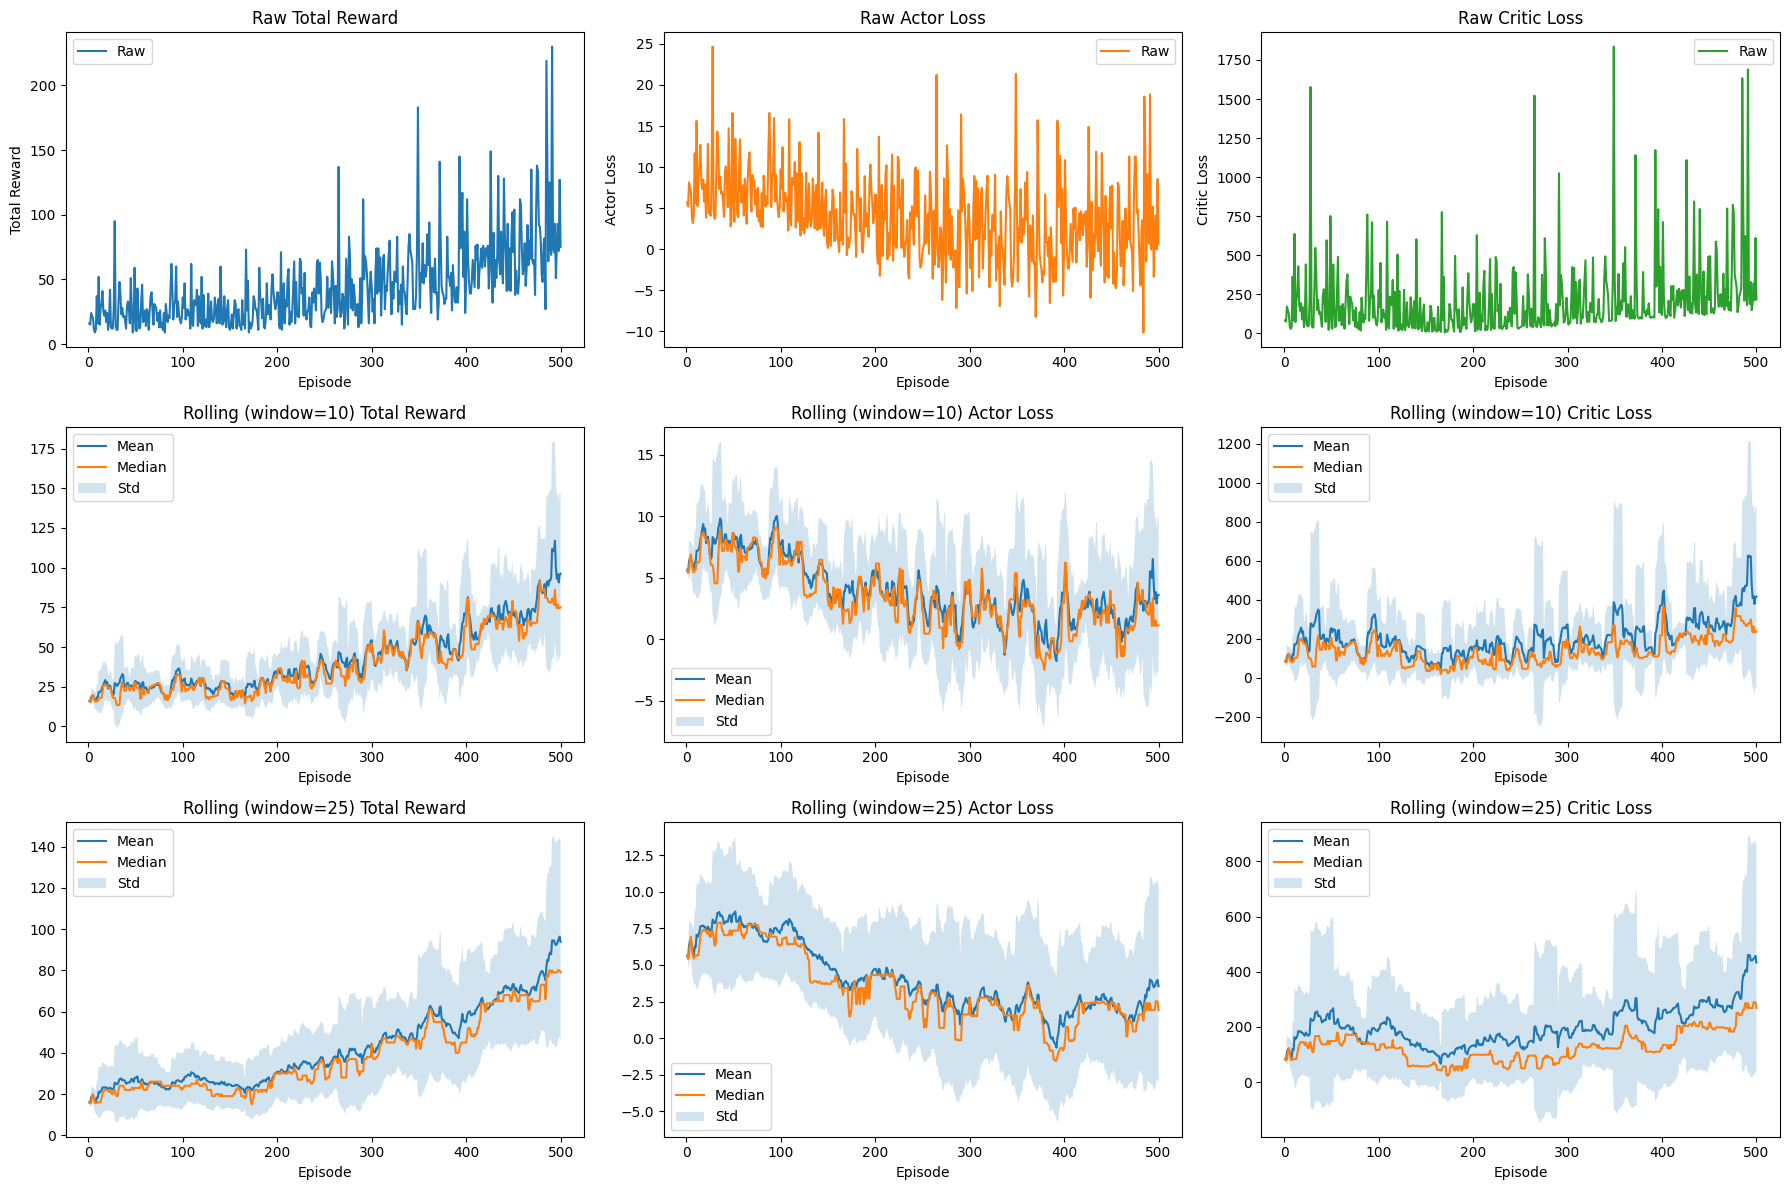

In [ ]:
# --------------------------
# Main Function to Run Training
# --------------------------
if __name__ == '__main__':
    env = gym.make("CartPole-v1")
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    # Configuration parameters
    config = {
        "actor_hidden_size": 128,
        "critic_hidden_size": 128,
        "actor_layers": 1,
        "critic_layers": 1,
        "actor_lr": 1e-3,
        "critic_lr": 1e-3,
        "num_episodes": 500,
        "gamma": 0.99
    }

    # Initialize agent with the configuration
    agent = ActorCriticAgent(
        obs_size, act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"]
    )

    # Start training
    total_rewards_history, actor_loss_history, critic_loss_history = train_agent(
        env,
        agent,
        num_episodes=config["num_episodes"],
        gamma=config["gamma"]
    )

plot_metrics(total_rewards_history, actor_loss_history, critic_loss_history, window_1=10, window_2=25)

Episode 10	Total Reward: 12.00	Actor Loss: 2.8810	Critic Loss: 28.6037
Episode 20	Total Reward: 25.00	Actor Loss: 4.3838	Critic Loss: 85.0415
Episode 30	Total Reward: 9.00	Actor Loss: -1.0730	Critic Loss: 8.3800
Episode 40	Total Reward: 16.00	Actor Loss: 0.1518	Critic Loss: 15.6505
Episode 50	Total Reward: 17.00	Actor Loss: -0.7816	Critic Loss: 5.5889
Episode 60	Total Reward: 30.00	Actor Loss: 2.6089	Critic Loss: 71.6780
Episode 70	Total Reward: 29.00	Actor Loss: -1.4332	Critic Loss: 84.5265
Episode 80	Total Reward: 39.00	Actor Loss: -0.7311	Critic Loss: 75.9740
Episode 90	Total Reward: 68.00	Actor Loss: -0.0740	Critic Loss: 225.3244
Episode 100	Total Reward: 88.00	Actor Loss: 3.9628	Critic Loss: 283.6516
Episode 110	Total Reward: 45.00	Actor Loss: -3.5826	Critic Loss: 119.2895
Episode 120	Total Reward: 88.00	Actor Loss: 5.6864	Critic Loss: 342.7065
Episode 130	Total Reward: 81.00	Actor Loss: 3.9147	Critic Loss: 225.2020
Episode 140	Total Reward: 80.00	Actor Loss: -0.0490	Critic Loss: 

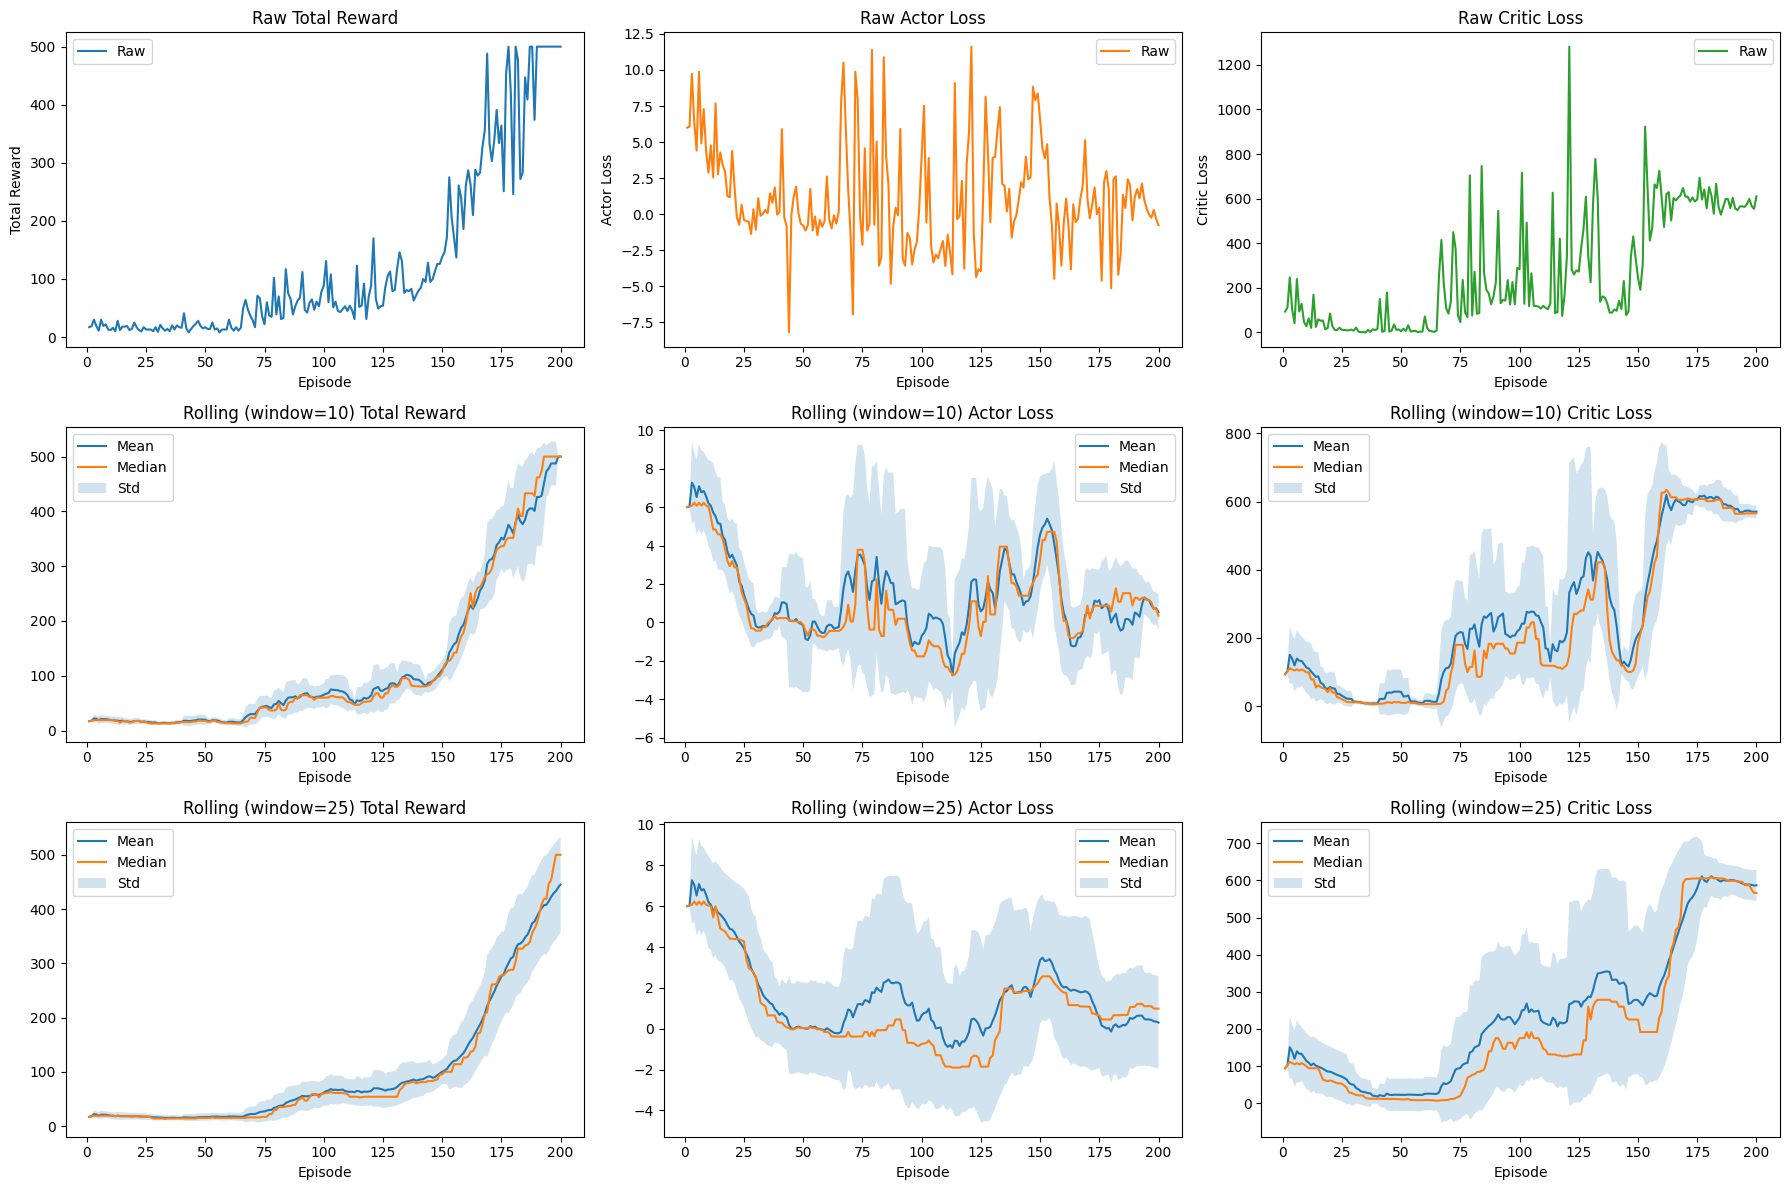

In [5]:
# --------------------------
# Main Function to Run Training
# --------------------------
if __name__ == '__main__':
    env = gym.make("CartPole-v1")
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    # Configuration parameters
    config = {
        "actor_hidden_size": 128,
        "critic_hidden_size": 128,
        "actor_layers": 1,
        "critic_layers": 1,
        "actor_lr": 1e-2,
        "critic_lr": 1e-2,
        "num_episodes": 200,
        "gamma": 0.99
    }

    # Initialize agent with the configuration
    agent = ActorCriticAgent(
        obs_size, act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"]
    )

    # Start training
    total_rewards_history, actor_loss_history, critic_loss_history = train_agent(
        env,
        agent,
        num_episodes=config["num_episodes"],
        gamma=config["gamma"]
    )

plot_metrics(total_rewards_history, actor_loss_history, critic_loss_history, window_1=10, window_2=25)